In [30]:
import numpy as np
from scipy.integrate import solve_ivp
from SALib.sample import saltelli, sobol, fast_sampler
from SALib.analyze import sobol, fast
import seaborn as sns
import SALib
import matplotlib.pyplot as plt
import math
from scipy.optimize import fsolve
from scipy.constants import N_A

In [31]:
#Constants

Target_cell_number = 2e5
E_T_ratio = 1
well_size = 150e-6
sigma = well_size*N_A/Target_cell_number
synapse_gap = 25e-9
synapse_width = 10e-6
tumour_cell_radius = 8e-6
tumour_cell_surface_area = 4*math.pi*((tumour_cell_radius)**2)
tumour_cell_IS_proportion = (synapse_width**2)/(tumour_cell_surface_area)
NK_cell_radius = 3.25e-6
NK_cell_surface_area = 4*math.pi*((NK_cell_radius)**2)
NK_cell_IS_proportion = (synapse_width**2)/NK_cell_surface_area
assay_to_synapse_conversion = (synapse_width**2*synapse_gap)/well_size
sigma_synapse = sigma*assay_to_synapse_conversion
synapse_area = synapse_width**2

In [32]:
def A1_steady_state(x, Atot, k1, koff, k2, rtot):
    express = 2*k1*(rtot - x - 2*(k2*x*(rtot-x)/(2*(koff + k2*x))))*(Atot - x - (k2*x*(rtot-x)/(2*(koff + k2*x)))) -koff*x - k2*x*(rtot - x - 2*(k2*x*(rtot-x)/(2*(koff + k2*x)))) +2*koff*(k2*x*(rtot-x)/(2*(koff + k2*x)))

    return express

def A2_steady_state(x, k2, koff, rtot):
    express = k2*x*(rtot-x)/(2*(koff + k2*x))

    return express

#Effector cell opsonization

def effector_A1(ftot, Atot, Q_D):

    a = 1
    b = -(ftot + Atot + Q_D)
    c = ftot*Atot
    if (b**2 - 4*a*c) <0:
        print(ftot, Atot/sigma, Q_D)
    
    return (-b - np.sqrt(b**2 - 4*a*c))/(2*a)

def effector_A1_1(ftot, Atot, Q_D):

    a = 1
    b = -(ftot + Atot + Q_D)
    c = ftot*Atot
    #if (b**2 - 4*a*c) <0:
     #   print(ftot, Atot, Q_D)
    return (-b - np.sqrt(b**2 - 4*a*c))/(2*a)

In [33]:
def calc_crosslinks(Ainit, kon, koff, D_t, rtot, qon, qoff, D_f, ftot):

    k2 = 4*D_t/tumour_cell_surface_area
    k1 = kon/sigma
    q1 = qon/sigma
    Q_D = qoff/q1
    k6 = 2*(D_t +D_f)/(synapse_area)  
    k7 = 2*D_t/synapse_area
    q1_bar = 2*(D_t+D_f)/synapse_area
    Q_D_bar = qoff/q1_bar
    Atot = Ainit*sigma
    
    A1_st_sin = fsolve(A1_steady_state, [1e-3], args=(Atot, k1, koff, k2, rtot))
    A2_st_sin = A2_steady_state(A1_st_sin, k2, koff, rtot)

    Atot = Atot - A1_st_sin - A2_st_sin
    Atot = Atot/E_T_ratio
    A1_E_stst = effector_A1(ftot, Atot, Q_D)
    if A1_E_stst <0:
        print(ftot, Atot)
    rtot_synapse = rtot*tumour_cell_IS_proportion
    A1_pre_synapse = A1_st_sin*tumour_cell_IS_proportion
    A2_pre_synapse = A2_st_sin*tumour_cell_IS_proportion
    A1_E_pre_synapse = A1_E_stst*NK_cell_IS_proportion
    ftot_synapse = ftot*NK_cell_IS_proportion
    A11_approx = 0
    A21_approx = 0
    fc_crosslinks = 0
    A10_approx = 0
    A20_approx = 0
    A01_approx = 0
    sol_guess = 0

    ftot_bar = ftot_synapse - A1_E_pre_synapse
    Atot_bar = A1_pre_synapse + A2_pre_synapse
    A1_synapse = effector_A1(ftot_bar, Atot_bar, Q_D_bar)
    A11_prop = A1_pre_synapse/(A1_pre_synapse + A2_pre_synapse)
    A21_prop = A2_pre_synapse/(A1_pre_synapse + A2_pre_synapse)
    A11_approx += A11_prop*A1_synapse
    A21_approx += A1_synapse*A21_prop
    A10_approx += (A1_pre_synapse - A11_approx)
    A20_approx += (A2_pre_synapse - A21_approx)
    sol_guess += A11_approx + 2*A21_approx
    A01_approx += A1_E_pre_synapse
    fc_crosslinks += A1_synapse

    rtot_bar = rtot_synapse - A1_pre_synapse - 2*A2_pre_synapse
    Atot_bar = A1_E_pre_synapse
    k1_bar = 2*(D_t + D_f)/synapse_area
    k2_bar = 2*D_t/synapse_area
    A1_st = fsolve(A1_steady_state, [1e-4], args=(Atot_bar, k1_bar, koff, k2_bar, rtot_bar))
    A2_st = A2_steady_state(A1_st, k2_bar, koff, rtot_bar)
    A11_approx += A1_st
    A21_approx += A2_st
    if A1_E_pre_synapse - A1_st -  A2_st <0:
        print(A1_E_pre_synapse, A1_st, A2_st)
    A01_approx +- A1_st + A2_st
    fc_crosslinks += (A1_st + A2_st)
    sol_guess += A1_st + 2*A2_st

    A1_E_stst = effector_A1_1(A01_approx , A01_approx , Q_D_bar)
    A1_st1 = fsolve(A1_steady_state, [1e-2], args=((fc_crosslinks + A1_E_stst) , k6, koff, k7, sol_guess))
    A2_st1 = A2_steady_state(A1_st1, k7, koff, sol_guess)
    correction = np.min([A1_E_stst - (A1_st1 + A2_st1 - fc_crosslinks) , A20_approx])

    crosslinks = A1_st1 + A2_st1 + correction

    return crosslinks


In [34]:
problem = {
    'num_vars': 9,
    'names': ['kon', 'koff', 'D_t', 'rtot', 'qon', 'qoff', 'D_f', 'ftot', 'dummy'],
    'bounds': [[4, 6],
               [-6, -4],
               [-15, -13],
               [4, 6],
               [3, 5],
               [-5, -3],
               [-15, -14],
               [4, 6],
               [1, 1000]]
}
problem1 = {
    'num_vars': 8,
    'names': ['kon', 'koff', 'D_t', 'qon', 'qoff', 'D_f', 'ftot', 'dummy'],
    'bounds': [[4, 6],
               [-6, -4],
               [-15, -13],
               [3, 5],
               [-5, -3],
               [-15, -14],
               [4, 6],
               [1, 1000]]
}

vals = SALib.sample.sobol.sample(problem1, 16384)
A0s = [1e-11, 1e-10, 1e-9, 1e-8, 1e-7, 1e-6, 1e-5]
Y = np.zeros(len(vals))
Y1 = np.zeros(len(vals))
Y2 = np.zeros(len(vals))
indicies = []

In [35]:
"""
Ainit = 1e-4
A0s= np.geomspace(1e-12, 1e-4, 100)
kon = 1e5
qon = 6.5e3
koff = 1e-4
qoff = 4.7e-3
rtot = 1e5
ftot= 2.2e5
D_t = 1e-14
D_f = 7.4e-14
calc_crosslinks(Ainit, kon, koff, D_t, rtot, qon, qoff, D_f, ftot)
sol = np.zeros_like(A0s)
for i, Ainit in enumerate(A0s):
    sol[i] = calc_crosslinks(Ainit, kon, koff, D_t, rtot, qon, qoff, D_f, ftot)
plt.semilogx(A0s, sol)
plt.show()
"""

'\nAinit = 1e-4\nA0s= np.geomspace(1e-12, 1e-4, 100)\nkon = 1e5\nqon = 6.5e3\nkoff = 1e-4\nqoff = 4.7e-3\nrtot = 1e5\nftot= 2.2e5\nD_t = 1e-14\nD_f = 7.4e-14\ncalc_crosslinks(Ainit, kon, koff, D_t, rtot, qon, qoff, D_f, ftot)\nsol = np.zeros_like(A0s)\nfor i, Ainit in enumerate(A0s):\n    sol[i] = calc_crosslinks(Ainit, kon, koff, D_t, rtot, qon, qoff, D_f, ftot)\nplt.semilogx(A0s, sol)\nplt.show()\n'

In [36]:
A0s = [1e-11, 1e-10, 1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4]
for Ainit in A0s:
    print(Ainit)
    for i, params in enumerate(vals):
        
        kon = params[0]
        kon = 10**kon
        koff = params[1]
        koff = 10**koff
        D_t = params[2]
        D_t = 10**D_t
        #rtot = params[3]
        #rtot = 10**rtot
        rtot = 1e6
        qon = params[3]
        qon = 10**qon
        qoff = params[4]
        qoff = 10**qoff
        D_f = params[5]
        D_f = 10**D_f
        ftot = params[6]
        ftot = 10**ftot
        dummy = params[7]
        
        Y[i] = calc_crosslinks(Ainit, kon, koff, D_t, rtot, qon, qoff, D_f, ftot)

    Si = sobol.analyze(problem1, Y, print_to_console=True)
    indicies.append(Si['ST'])

1e-11
[7.32352271e-09] [1.50434075e-16] [7.32352256e-09]
[1.40330974e-09] [2.8571634e-17] [1.40330971e-09]
[1.48005324e-09] [2.52696616e-17] [1.48005322e-09]
[1.71028375e-08] [2.35401344e-16] [1.71028372e-08]
[7.77959838e-08] [1.07077432e-15] [7.77959827e-08]
[1.13865429e-07] [1.56722972e-15] [1.13865428e-07]
[8.77068588e-10] [1.83834324e-17] [8.7706857e-10]
[3.50827435e-10] [4.57656041e-18] [3.50827431e-10]
[1.75413718e-09] [3.14019134e-17] [1.75413714e-09]
[9.64775447e-10] [1.10732245e-17] [9.64775436e-10]
[6.13948012e-09] [6.86204626e-17] [6.13948005e-09]
[7.19196242e-09] [1.50833683e-16] [7.19196227e-09]
[3.50827435e-10] [8.15764193e-18] [3.50827427e-10]
[2.02602844e-08] [3.01374664e-16] [2.02602841e-08]
[4.56075666e-09] [4.02228376e-17] [4.56075662e-09]
[2.80661948e-09] [4.42434843e-17] [2.80661944e-09]
[2.89432634e-08] [4.08899595e-16] [2.8943263e-08]
[2.889941e-08] [4.11915105e-16] [2.88994096e-08]
[3.15744692e-09] [4.50043817e-17] [3.15744687e-09]
[2.24529559e-08] [7.43933512e-

/opt/homebrew/lib/python3.10/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


[7.0165487e-09] [1.30614375e-16] [7.01654857e-09]
[1.19281328e-08] [2.22044437e-16] [1.19281326e-08]
[2.45579205e-08] [4.09292218e-16] [2.45579201e-08]
[0.] [8.636e-321] [0.]
[8.72683245e-09] [1.58461195e-16] [8.72683229e-09]
[5.13085124e-09] [9.91545116e-17] [5.13085114e-09]
[5.03437369e-08] [8.58428521e-16] [5.03437361e-08]
[3.9117259e-08] [6.46353983e-16] [3.91172584e-08]
[3.9117259e-08] [6.46353983e-16] [3.91172584e-08]
[3.9117259e-08] [6.46353983e-16] [3.91172584e-08]
[5.61323896e-09] [8.00499388e-17] [5.61323888e-09]
[1.40330974e-09] [2.62596691e-17] [1.40330971e-09]
[2.10496461e-09] [3.93895036e-17] [2.10496457e-09]
[2.10496461e-09] [3.93895036e-17] [2.10496457e-09]
[2.10496461e-09] [3.93895036e-17] [2.10496457e-09]
[4.75371175e-08] [8.397198e-16] [4.75371166e-08]
[1.368227e-08] [2.4169057e-16] [1.36822697e-08]
[4.75371175e-08] [8.397198e-16] [4.75371166e-08]
[4.75371175e-08] [8.397198e-16] [4.75371166e-08]
[1.97340432e-09] [4.25750108e-17] [1.97340428e-09]
[4.56075666e-09] [4.9

/opt/homebrew/lib/python3.10/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


[1.95410881e-07] [3.0686938e-15] [1.95410878e-07]
[6.35699313e-07] [1.06501367e-14] [6.35699302e-07]
[5.61323896e-09] [1.11310859e-16] [5.61323885e-09]
[1.40330974e-09] [1.55227046e-17] [1.40330973e-09]
[6.66572127e-09] [1.20112479e-16] [6.66572115e-09]
[6.66572127e-09] [1.20112479e-16] [6.66572115e-09]
[6.66572127e-09] [1.20112479e-16] [6.66572115e-09]
[8.49002393e-08] [2.66381991e-15] [8.49002366e-08]
[5.05191507e-08] [9.36101141e-16] [5.05191497e-08]
[7.80591043e-09] [1.28987528e-16] [7.8059103e-09]
[4.38534294e-09] [7.31435926e-17] [4.38534287e-09]
[7.19196242e-09] [9.68121863e-17] [7.19196232e-09]
[1.26297877e-08] [2.82770143e-16] [1.26297874e-08]
[1.82430266e-08] [1.95476955e-16] [1.82430264e-08]
[1.82430266e-08] [1.95476955e-16] [1.82430264e-08]
[1.82430266e-08] [1.95476955e-16] [1.82430264e-08]
[2.66628851e-08] [4.01128363e-16] [2.66628847e-08]
[1.0945816e-07] [1.26155651e-15] [1.09458159e-07]
[1.69379486e-06] [3.32518132e-14] [1.69379482e-06]
[1.69379486e-06] [3.32518132e-14] 

/opt/homebrew/lib/python3.10/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


                 ST       ST_conf
kon    2.445704e-05  1.952774e-06
koff   2.031771e-07  1.639201e-08
D_t    1.766823e-03  8.900491e-05
qon    5.218605e-02  1.990515e-03
qoff   5.235457e-02  1.902043e-03
D_f    5.408949e-04  3.314951e-05
ftot   9.508912e-01  1.498264e-02
dummy  0.000000e+00  0.000000e+00
                 S1   S1_conf
kon    1.351514e-05  0.000089
koff   1.089927e-07  0.000011
D_t    6.746000e-04  0.000959
qon   -2.977249e-03  0.004239
qoff  -2.966153e-03  0.004696
D_f    7.260556e-05  0.000501
ftot   9.300824e-01  0.016692
dummy  0.000000e+00  0.000000
                         S2   S2_conf
(kon, koff)   -2.950901e-06  0.000132
(kon, D_t)     1.173247e-06  0.000134
(kon, qon)     3.541669e-06  0.000135
(kon, qoff)   -1.073159e-05  0.000137
(kon, D_f)    -3.407335e-06  0.000133
(kon, ftot)   -1.578263e-05  0.000126
(kon, dummy)  -2.965210e-06  0.000132
(koff, D_t)    2.777342e-07  0.000017
(koff, qon)    2.816570e-06  0.000017
(koff, qoff)   4.433893e-07  0.000017
(koff,

/opt/homebrew/lib/python3.10/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


                 ST       ST_conf
kon    5.891499e-04  4.201940e-05
koff   2.201537e-08  1.741379e-09
D_t    1.416290e-03  8.525570e-05
qon    8.166187e-02  3.243327e-03
qoff   8.173775e-02  3.517836e-03
D_f    3.085708e-04  2.667033e-05
ftot   9.493883e-01  1.769670e-02
dummy  0.000000e+00  0.000000e+00
                 S1   S1_conf
kon    1.014538e-04  0.000556
koff   1.930799e-07  0.000004
D_t   -1.625236e-04  0.000780
qon    2.279328e-02  0.006608
qoff   2.222374e-02  0.007311
D_f    5.729856e-05  0.000412
ftot   8.659366e-01  0.016672
dummy  0.000000e+00  0.000000
                         S2   S2_conf
(kon, koff)    1.318944e-04  0.000795
(kon, D_t)     1.900261e-04  0.000795
(kon, qon)     7.804447e-05  0.000795
(kon, qoff)    5.067507e-05  0.000773
(kon, D_f)     1.332879e-04  0.000793
(kon, ftot)    1.295547e-04  0.000726
(kon, dummy)   1.318626e-04  0.000795
(koff, D_t)    5.789225e-07  0.000005
(koff, qon)   -6.005751e-07  0.000006
(koff, qoff)   6.400916e-07  0.000005
(koff,

/opt/homebrew/lib/python3.10/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


                 ST       ST_conf
kon    1.241089e-02  6.066953e-04
koff   3.986451e-09  3.388494e-10
D_t    1.197724e-02  5.856836e-04
qon    9.772422e-02  5.789056e-03
qoff   9.793038e-02  5.448793e-03
D_f    6.378097e-05  1.115593e-05
ftot   9.274716e-01  2.102123e-02
dummy  0.000000e+00  0.000000e+00
                 S1   S1_conf
kon    4.864324e-03  0.001973
koff   7.848418e-08  0.000001
D_t    4.443494e-03  0.002388
qon    3.064846e-02  0.007123
qoff   3.014401e-02  0.006984
D_f    5.278821e-05  0.000171
ftot   8.254237e-01  0.017593
dummy  0.000000e+00  0.000000
                         S2   S2_conf
(kon, koff)    1.217625e-04  0.002880
(kon, D_t)     1.890219e-03  0.002792
(kon, qon)    -3.741854e-05  0.002970
(kon, qoff)    1.120590e-04  0.002977
(kon, D_f)     1.119056e-04  0.002881
(kon, ftot)    4.000505e-03  0.002856
(kon, dummy)   1.217188e-04  0.002880
(koff, D_t)    2.426465e-07  0.000002
(koff, qon)   -3.523602e-08  0.000002
(koff, qoff)   2.387469e-07  0.000002
(koff,

/opt/homebrew/lib/python3.10/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


                 ST       ST_conf
kon    1.305354e-01  5.121659e-03
koff   6.868420e-10  5.373037e-11
D_t    1.296372e-01  4.247794e-03
qon    1.177242e-02  1.659741e-03
qoff   1.149569e-02  1.258113e-03
D_f    8.632511e-07  1.673133e-07
ftot   8.352013e-01  1.562915e-02
dummy  0.000000e+00  0.000000e+00
                 S1       S1_conf
kon    7.028815e-02  7.684156e-03
koff  -1.466526e-08  6.095214e-07
D_t    7.066503e-02  7.540596e-03
qon    3.262292e-03  2.308470e-03
qoff   2.528161e-03  2.184077e-03
D_f    3.634603e-06  2.095240e-05
ftot   7.469641e-01  1.775146e-02
dummy  0.000000e+00  0.000000e+00
                         S2       S2_conf
(kon, koff)    5.328258e-04  1.041361e-02
(kon, D_t)     1.590548e-02  1.122580e-02
(kon, qon)     5.424678e-04  1.037925e-02
(kon, qoff)    1.154627e-03  1.038503e-02
(kon, D_f)     5.330024e-04  1.041233e-02
(kon, ftot)    3.701379e-02  1.100355e-02
(kon, dummy)   5.327524e-04  1.041358e-02
(koff, D_t)    1.477296e-07  7.718236e-07
(koff, qon

/opt/homebrew/lib/python3.10/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


                 ST       ST_conf
kon    3.632558e-01  8.916986e-03
koff   6.143619e-11  4.658015e-12
D_t    3.627039e-01  8.213254e-03
qon    1.769885e-04  2.142413e-05
qoff   1.774760e-04  2.328946e-05
D_f    2.962129e-07  4.405346e-08
ftot   4.582098e-01  1.550727e-02
dummy  0.000000e+00  0.000000e+00
                 S1       S1_conf
kon    2.627058e-01  1.184986e-02
koff  -2.471145e-08  1.826912e-07
D_t    2.642948e-01  1.215979e-02
qon    1.059233e-04  2.627852e-04
qoff  -1.685254e-05  3.041455e-04
D_f   -3.092034e-07  1.276762e-05
ftot   2.998835e-01  1.447549e-02
dummy  0.000000e+00  0.000000e+00
                         S2       S2_conf
(kon, koff)    5.094442e-04  1.473513e-02
(kon, D_t)     1.498295e-02  1.683340e-02
(kon, qon)     4.791813e-04  1.471580e-02
(kon, qoff)    5.536503e-04  1.472823e-02
(kon, D_f)     5.091496e-04  1.473623e-02
(kon, ftot)    7.404886e-02  1.627916e-02
(kon, dummy)   5.094013e-04  1.473515e-02
(koff, D_t)    5.973802e-08  2.374021e-07
(koff, qon

8


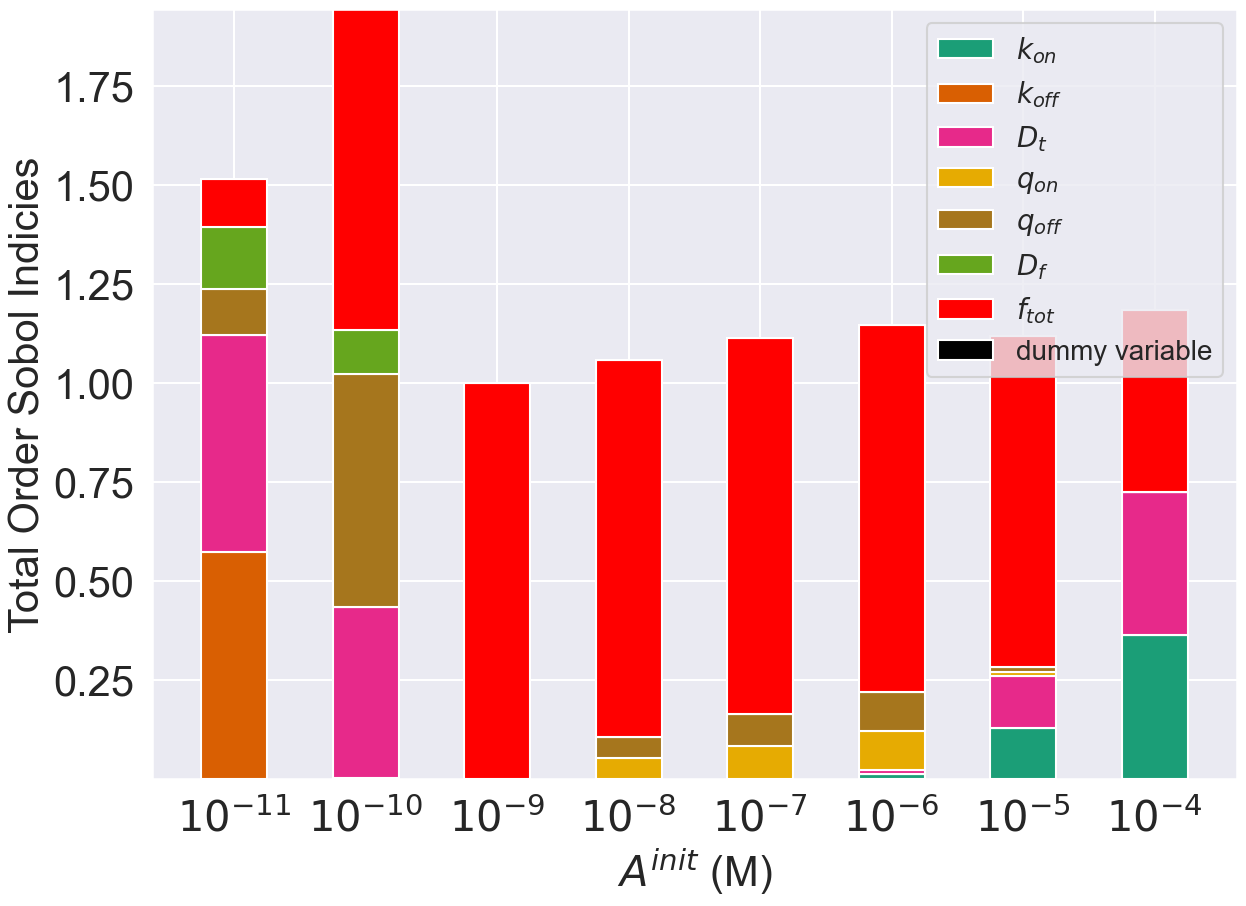

In [37]:
kon_si = np.zeros(len(A0s))
koff_si = np.zeros(len(A0s))
D_t_si = np.zeros(len(A0s))
rtot_si = np.zeros(len(A0s))
qon_si = np.zeros(len(A0s))
qoff_si = np.zeros(len(A0s))
D_f_si = np.zeros(len(A0s))
ftot_si = np.zeros(len(A0s))
dummy_si = np.zeros(len(A0s))


for i in range(len(indicies)):
    vals = indicies[i]
    kon_si[i] = vals[0]
    koff_si[i] = vals[1]
    D_t_si[i] = vals[2]
    #rtot_si[i] = vals[3]
    qon_si[i] = vals[3]
    qoff_si[i] = vals[4]
    D_f_si[i] = vals[5]
    ftot_si[i] = vals[6]
    dummy_si[i] = vals[7]

print(len(indicies))
ab_conc = ( r'$10^{-11}$', r'$10^{-10}$', r'$10^{-9}$', r'$10^{-8}$', r'$10^{-7}$', r'$10^{-6}$', r'$10^{-5}$', r'$10^{-4}$')


sns.set_theme()
sns.set_context("talk")

width = 0.5
fig, ax = plt.subplots(figsize=(14,10))
bottom = np.zeros(8)

cm = plt.cm.get_cmap('Dark2')
ax.bar(ab_conc, kon_si, width, label=r'$k_{on}$', bottom= bottom, color=cm(0))
bottom+= kon_si
ax.bar(ab_conc, koff_si, width, label=r'$k_{off}$', bottom= bottom, color=cm(1))
bottom+= koff_si
ax.bar(ab_conc, D_t_si, width, label=r'$D_t$', bottom= bottom, color=cm(3))
bottom+= D_t_si
#ax.bar(ab_conc, rtot_si, width, label=r'$r_{tot}$', bottom= bottom, color='blue')
#bottom+= rtot_si
ax.bar(ab_conc, qon_si, width, label=r'$q_{on}$', bottom= bottom, color=cm(5))
bottom+= qon_si
ax.bar(ab_conc, qoff_si, width, label=r'$q_{off}$', bottom= bottom, color=cm(6))
bottom+= qoff_si
ax.bar(ab_conc, D_f_si, width, label=r'$D_f$', bottom= bottom, color=cm(4))
bottom+= D_f_si
ax.bar(ab_conc, ftot_si, width, label=r'$f_{tot}$', bottom= bottom, color='red')
bottom+= ftot_si
ax.bar(ab_conc, dummy_si, width, label='dummy variable', bottom=bottom, color='black')
ax.legend(loc='best', fontsize=20)
ax.tick_params(labelsize=30)
ax.set_xlabel(r'$A^{init}$' + ' (M)', fontsize=30)
ax.set_ylabel('Total Order Sobol Indicies', fontsize=30)
plt.savefig('/Users/lukeheirene/ADCC-Project/Figures/synapse_approx_sa_no_div_ET1_rtot_1e6.png')